In [2]:
import os, json, math, random, time, shutil, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

In [4]:
BASE = "/content/drive/MyDrive/Colab Notebooks/FER"
DATA = f"{BASE}/data"
OUT  = f"{BASE}/artifacts_face"
os.makedirs(OUT, exist_ok=True)

In [5]:
CLASSES = ["happy","sad","angry","fear","surprise","neutral","disgust"]
CLASS2IDX = {c:i for i,c in enumerate(CLASSES)}
IDX2CLASS = {i:c for c,i in CLASS2IDX.items()}

FER_MAP = {0:"angry",1:"disgust",2:"fear",3:"happy",4:"sad",5:"surprise",6:"neutral"}
RAF_MAP = {1:"surprise", 2:"fear", 3:"disgust", 4:"happy", 5:"sad", 6:"angry", 7:"neutral"}


In [6]:
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

In [8]:
train_tf = A.Compose([
    A.Resize(256,256),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.2,0.2,0.2,0.1, p=0.5),
    A.RandomBrightnessContrast(0.2,0.2, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=IMG_SIZE//8, max_width=IMG_SIZE//8, p=0.3),
    A.Normalize(MEAN, STD),
    ToTensorV2()
])

In [9]:
val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(MEAN, STD),
    ToTensorV2()
])

In [16]:
class RAFDataset(Dataset):
    def __init__(self, root, split="train", transform=None, exts=(".jpg",".jpeg",".png",".bmp",".webp")):
        self.items = []
        split_root = os.path.join(root, "DATASET", split)
        if not os.path.isdir(split_root):
            raise FileNotFoundError(f"RAF split not found: {split_root}")

        for folder in sorted(os.listdir(split_root)):
            if not folder.isdigit():
                continue
            k = int(folder)
            if k not in RAF_MAP:
                continue
            cls_name = RAF_MAP[k]
            cls_idx = CLASS2IDX[cls_name]
            fdir = os.path.join(split_root, folder)
            for fn in os.listdir(fdir):
                if fn.lower().endswith(exts):
                    self.items.append((os.path.join(fdir, fn), cls_idx))

        if not self.items:
            raise RuntimeError(f"No images found under {split_root}.")
        self.transform = transform

        self.labels = np.array([y for _, y in self.items], dtype=np.int64)

    def __len__(self): return len(self.items)

    def __getitem__(self, i):
        fp, y = self.items[i]
        im = np.array(Image.open(fp).convert("RGB"))
        if self.transform:
            im = self.transform(image=im)["image"]
        return im, y, {"src":"raf", "path":fp}


In [17]:
class FER2013Dataset(Dataset):
    def __init__(self, root, split="train", transform=None, exts=(".jpg",".jpeg",".png",".bmp")):
        self.items = []
        split_root = os.path.join(root, split)
        if not os.path.isdir(split_root):
            raise FileNotFoundError(f"FER split not found: {split_root}")

        valid_map = {
            "angry":"angry","disgust":"disgust","fear":"fear",
            "happy":"happy","sad":"sad","surprise":"surprise","neutral":"neutral"
        }
        for cls in sorted(os.listdir(split_root)):
            c = valid_map.get(cls.lower())
            if c is None:
                continue
            cls_idx = CLASS2IDX[c]
            cdir = os.path.join(split_root, cls)
            for fn in os.listdir(cdir):
                if fn.lower().endswith(exts):
                    self.items.append((os.path.join(cdir, fn), cls_idx))

        if not self.items:
            raise RuntimeError(f"No images found under {split_root}. Check class folder names.")
        self.transform = transform

        self.labels = np.array([y for _, y in self.items], dtype=np.int64)

    def __len__(self): return len(self.items)

    def __getitem__(self, i):
        fp, y = self.items[i]
        im = np.array(Image.open(fp).convert("RGB"))
        if self.transform:
            im = self.transform(image=im)["image"]
        return im, y, {"src":"fer", "path":fp}


In [18]:
raf_train = RAFDataset(f"{DATA}/raf-db-dataset", split="train", transform=train_tf)
raf_val   = RAFDataset(f"{DATA}/raf-db-dataset", split="test",  transform=val_tf)
fer_train = FER2013Dataset(f"{DATA}/fer2013",    split="train", transform=train_tf)
fer_val   = FER2013Dataset(f"{DATA}/fer2013",    split="test",  transform=val_tf)

print("RAF:", len(raf_train), len(raf_val))
print("FER:", len(fer_train), len(fer_val))

x, y, meta = raf_train[0]
print("One RAF sample:", x.shape, CLASSES[y], meta["path"])


RAF: 12271 3068
FER: 28709 7178
One RAF sample: torch.Size([3, 224, 224]) surprise /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/1/train_01561_aligned.jpg


In [19]:
from torch.utils.data import ConcatDataset, DataLoader

train_ds = ConcatDataset([raf_train, fer_train])
val_ds   = ConcatDataset([raf_val,   fer_val])


In [20]:
def class_counts_fast(ds, n_classes: int):
    counts = np.zeros(n_classes, dtype=np.int64)
    if isinstance(ds, ConcatDataset):
        for sub in ds.datasets:
            if hasattr(sub, "labels"):
                counts += np.bincount(sub.labels, minlength=n_classes)
            else:
                raise RuntimeError("Subdataset missing .labels; add it in __init__.")
    else:
        if hasattr(ds, "labels"):
            counts += np.bincount(ds.labels, minlength=n_classes)
        else:
            raise RuntimeError("Dataset missing .labels; add it in __init__.")
    return counts

N_CLASSES = len(CLASSES)
counts = class_counts_fast(train_ds, N_CLASSES)

class_weights = (counts.sum() / np.maximum(counts, 1)).astype(np.float32)
class_weights = class_weights / class_weights.mean()
CLASS_WEIGHTS_T = torch.tensor(class_weights, device=DEVICE)

In [21]:
NUM_WORKERS = 2
BATCH = 64
train_loader = DataLoader(
    train_ds, batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=NUM_WORKERS>0
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=NUM_WORKERS>0
)

counts, class_weights

(array([11987,  6812,  4700,  4378,  4461,  7489,  1153]),
 array([0.30793378, 0.5418676 , 0.7853622 , 0.8431252 , 0.8274383 ,
        0.49288324, 3.2013898 ], dtype=float32))

In [7]:
MODEL_NAME = "efficientnet_b0"
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(CLASSES))
model.to(DEVICE)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [23]:
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS_T, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
steps_per_epoch = math.ceil(len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=12,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.15,
    div_factor=10,
    final_div_factor=10
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

In [25]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.0 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassF1Score, MulticlassConfusionMatrix

def evaluate(model, loader):
    model.eval()
    f1 = MulticlassF1Score(num_classes=len(CLASSES), average="macro").to(DEVICE)
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)
            logits = model(x)
            preds = logits.argmax(1)
            f1.update(preds, y)
            all_preds.append(preds.cpu()); all_tgts.append(y.cpu())
    f1m = f1.compute().item()
    y_true = torch.cat(all_tgts); y_pred = torch.cat(all_preds)
    cm = MulticlassConfusionMatrix(num_classes=len(CLASSES)).to(DEVICE)
    cm_val = cm(y_pred.to(DEVICE), y_true.to(DEVICE)).cpu().numpy()
    acc = (y_true == y_pred).float().mean().item()
    return {"f1_macro": f1m, "acc": acc, "cm": cm_val}

BEST = {"f1_macro": 0, "path": None}
EPOCHS = 12

In [ ]:
for ep in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for i, (x, y, _) in enumerate(train_loader, start=1):
        x, y = x.to(DEVICE, non_blocking=True), torch.tensor(y).to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        scheduler.step()
        running += loss.item()

    val = evaluate(model, val_loader)
    print(f"Epoch {ep:02d} | loss {running/i:.4f} | F1-macro {val['f1_macro']:.4f} | Acc {val['acc']:.4f}")

    if val["f1_macro"] > BEST["f1_macro"]:
        BEST["f1_macro"] = val["f1_macro"]
        BEST["path"] = f"{OUT}/best_{MODEL_NAME}_f1_{val['f1_macro']:.4f}.pt"
        torch.save({"model": model.state_dict(),
                    "classes": CLASSES, "mean": MEAN, "std": STD,
                    "img_size": IMG_SIZE, "model_name": MODEL_NAME}, BEST["path"])
        with open(f"{OUT}/preprocess.json","w") as f:
            json.dump({"classes": CLASSES, "mean": MEAN, "std": STD, "img_size": IMG_SIZE}, f)
        print("✅ Saved:", BEST["path"])

Epoch 01 | loss 1.8887 | F1-macro 0.4895 | Acc 0.5332
✅ Saved: /content/drive/MyDrive/Colab Notebooks/FER/artifacts_face/best_efficientnet_b0_f1_0.4895.pt


In [9]:
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/FER/artifacts_face/best_efficientnet_b0_f1_0.4895.pt"

ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt["model"], strict=True)
model.to(DEVICE)
model.eval()

print("✅ Restored model from:", ckpt_path)

✅ Restored model from: /content/drive/MyDrive/Colab Notebooks/FER/artifacts_face/best_efficientnet_b0_f1_0.4895.pt


In [10]:
prep_json = os.path.join(OUT, "preprocess.json")
if os.path.exists(prep_json):
    with open(prep_json, "r") as f:
        prep = json.load(f)
    IMG_SIZE = prep["img_size"]; MEAN = prep["mean"]; STD = prep["std"]
    CLASSES = prep["classes"]
    print("Loaded preprocess config:", prep_json)


Loaded preprocess config: /content/drive/MyDrive/Colab Notebooks/FER/artifacts_face/preprocess.json


In [12]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.5 MB/s eta 0:00:00


In [13]:
import torch

onnx_path = f"{OUT}/{MODEL_NAME}_face.onnx"
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device="cpu")
model_cpu = model.to("cpu").eval()

torch.onnx.export(
    model_cpu,
    dummy,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    opset_version=17,
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
)

print("✅ Exported ONNX:", onnx_path)


✅ Exported ONNX: /content/drive/MyDrive/Colab Notebooks/FER/artifacts_face/efficientnet_b0_face.onnx


In [14]:
model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
onnx_path = f"{OUT}/{MODEL_NAME}_face.onnx"
torch.onnx.export(model, dummy, onnx_path, input_names=["input"], output_names=["logits"], opset_version=17, dynamic_axes={"input":{0:"batch"}, "logits":{0:"batch"}})
print("Exported:", onnx_path)


Exported: /content/drive/MyDrive/Colab Notebooks/FER/artifacts_face/efficientnet_b0_face.onnx


Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/7/train_09830_aligned.jpg
Ground truth: neutral
Predicted: disgust (p=0.546)
Top-3: [('disgust', 0.5458964705467224), ('surprise', 0.17370039224624634), ('neutral', 0.12636815011501312)]


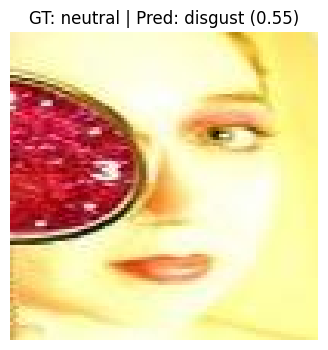

Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/test/6/test_1815_aligned.jpg
Ground truth: angry
Predicted: angry (p=0.393)
Top-3: [('angry', 0.3931548297405243), ('surprise', 0.24665950238704681), ('disgust', 0.14237505197525024)]


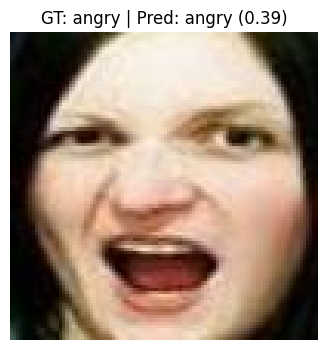

Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/5/train_07426_aligned.jpg
Ground truth: sad
Predicted: sad (p=0.660)
Top-3: [('sad', 0.6602091193199158), ('neutral', 0.11445106565952301), ('disgust', 0.0988679751753807)]


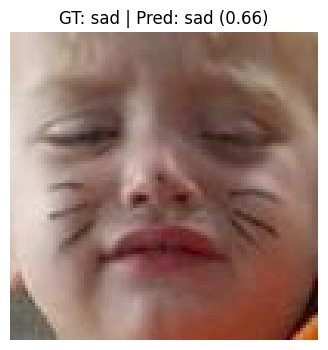

Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/2/train_09190_aligned.jpg
Ground truth: fear
Predicted: surprise (p=0.662)
Top-3: [('surprise', 0.6619715690612793), ('happy', 0.15609917044639587), ('fear', 0.08416608721017838)]


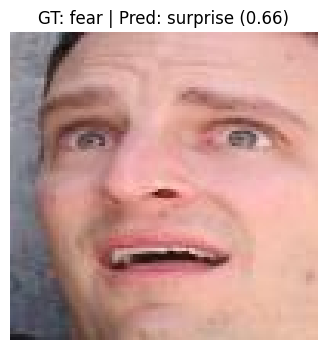

Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/6/train_06793_aligned.jpg
Ground truth: angry
Predicted: disgust (p=0.868)
Top-3: [('disgust', 0.8682640194892883), ('angry', 0.06097690761089325), ('sad', 0.04030832275748253)]


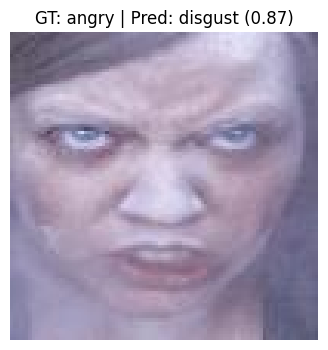

Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/4/train_00831_aligned.jpg
Ground truth: happy
Predicted: happy (p=0.602)
Top-3: [('happy', 0.6021174192428589), ('neutral', 0.19160740077495575), ('disgust', 0.08813273161649704)]


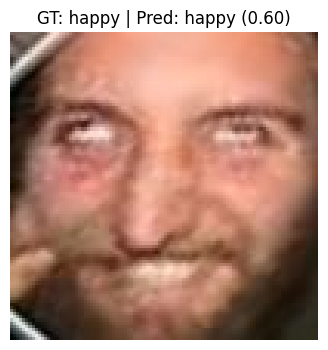

Image: /content/drive/MyDrive/Colab Notebooks/FER/data/raf-db-dataset/DATASET/train/1/train_06643_aligned.jpg
Ground truth: surprise
Predicted: disgust (p=0.397)
Top-3: [('disgust', 0.3969440758228302), ('neutral', 0.1853117197751999), ('sad', 0.17365634441375732)]


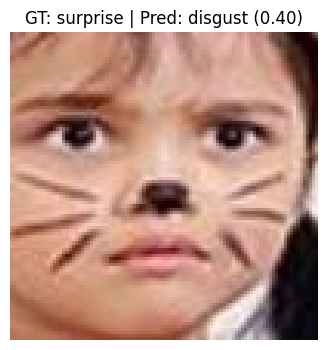

In [28]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def preprocess_pil(pil):
    tf = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(MEAN, STD),
    ])
    return tf(pil).unsqueeze(0).to(DEVICE)

def pick_random_image():
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    candidates = []
    for split in ("train","test"):
        for cls_num in ("1","2","3","4","5","6","7"):
            for ext in exts:
                candidates += glob(os.path.join(DATA, "raf-db-dataset", "DATASET", split, cls_num, ext))
    if not candidates:
        for split in ("train","test"):
            for cls in ["angry","disgust","fear","happy","sad","surprise","neutral"]:
                for ext in exts:
                    candidates += glob(os.path.join(DATA, "fer2013", split, cls, ext))
    if not candidates:
        raise FileNotFoundError("No images found in RAF or FER folders.")
    return random.choice(candidates)

def get_ground_truth_from_path(path):
    parts = os.path.normpath(path).split(os.sep)
    if "raf-db-dataset" in parts:
        cls_num = parts[-2]
        gt = RAF_MAP.get(int(cls_num), "unknown")
    elif "fer2013" in parts:
        gt = parts[-2].lower()
    else:
        gt = "unknown"
    return gt

def infer_and_show(sample_path):
    img = Image.open(sample_path).convert("RGB")
    x = preprocess_pil(img)
    with torch.no_grad():
        logits = model(x)
        probs  = F.softmax(logits, dim=1).cpu().numpy()[0]
    top3 = np.argsort(-probs)[:3]
    pred = CLASSES[top3[0]]
    gt = get_ground_truth_from_path(sample_path)

    print("Image:", sample_path)
    print("Ground truth:", gt)
    print("Predicted:", pred, f"(p={probs[top3[0]]:.3f})")
    print("Top-3:", [(CLASSES[i], float(probs[i])) for i in top3])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"GT: {gt} | Pred: {pred} ({probs[top3[0]]:.2f})")
    plt.show()

sample_path = pick_random_image()
infer_and_show(sample_path)
sample_path = pick_random_image()
infer_and_show(sample_path)
sample_path = pick_random_image()
infer_and_show(sample_path)
sample_path = pick_random_image()
infer_and_show(sample_path)
sample_path = pick_random_image()
infer_and_show(sample_path)
sample_path = pick_random_image()
infer_and_show(sample_path)
sample_path = pick_random_image()
infer_and_show(sample_path)